In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
import numpy as np
from scipy import stats
import glob
from matplotlib import pyplot as plt
from scipy.stats import norm 

# load classification tests in result folder

In [3]:
df_mn_details = pd.read_csv("../../data/processed/moleculenet/details.tsv", sep="\t", header=None)
df_tdc_details = pd.read_csv("../../data/processed/tdc/details.tsv", sep="\t", header=None)

In [4]:
mn_results_paths = glob.glob("../../data/result/moleculenet_scores/*.tsv")
tdc_results_paths = glob.glob("../../data/result/tdc_scores/*.tsv")

In [5]:
task_names = []
for i in range(len(df_mn_details)):
    task = f"{df_mn_details.iloc[i,0]}/{df_mn_details.iloc[i,1]}"
    if df_mn_details.iloc[i,5] == 2:
        task_names.append(task)
for i in range(len(df_tdc_details)):
    task = f"{df_tdc_details.iloc[i,0]}/{df_tdc_details.iloc[i,1]}"
    if df_tdc_details.iloc[i,5] == 2:
        task_names.append(task)

# run classification task (0.2 <= positive ratio <= 0.8)

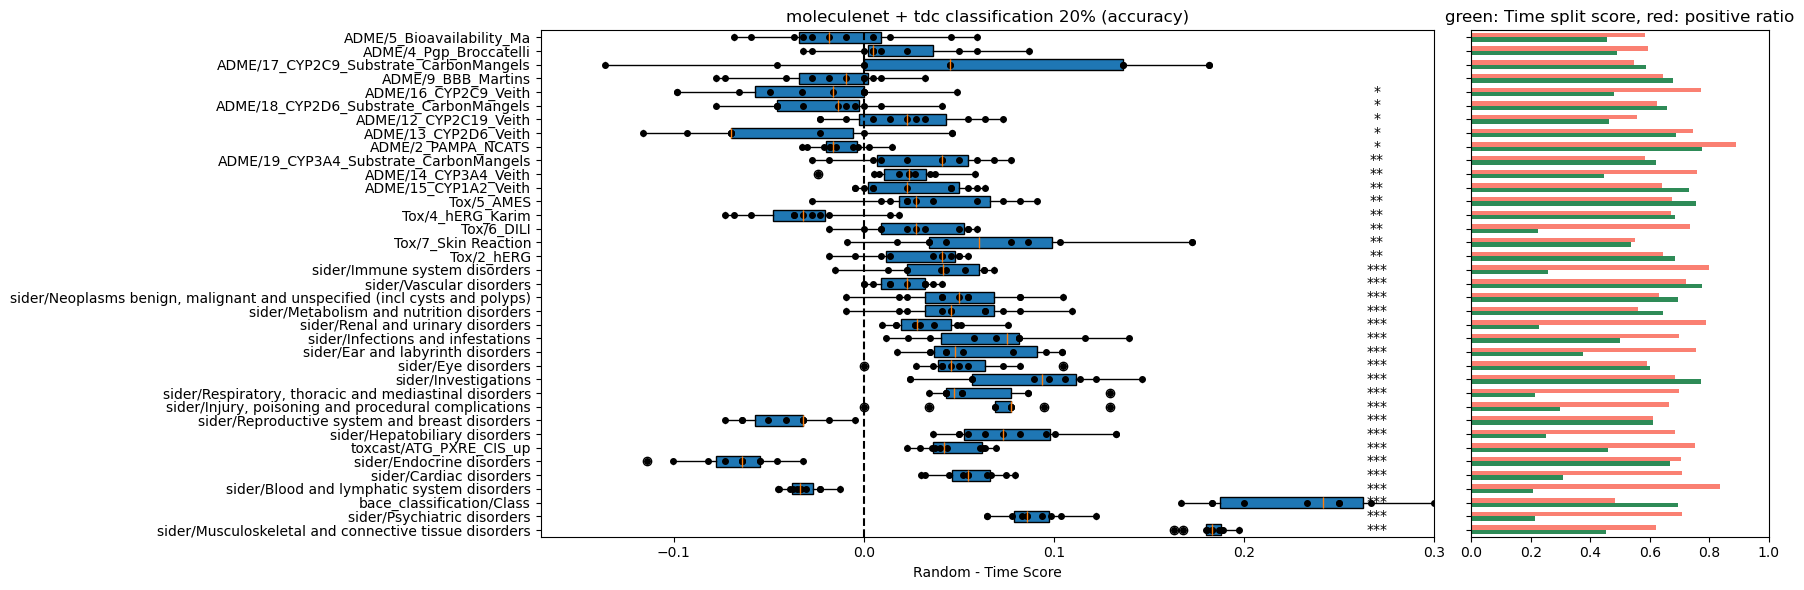

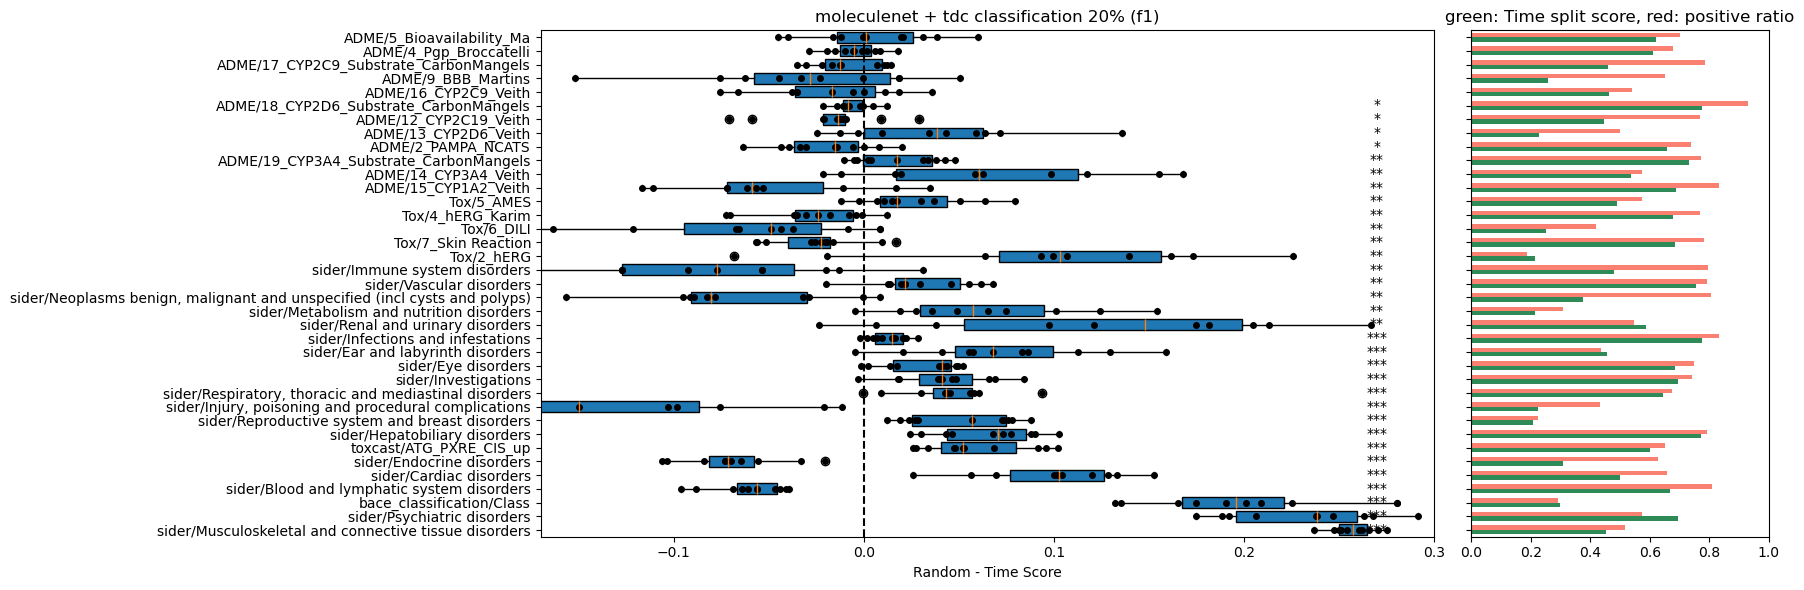

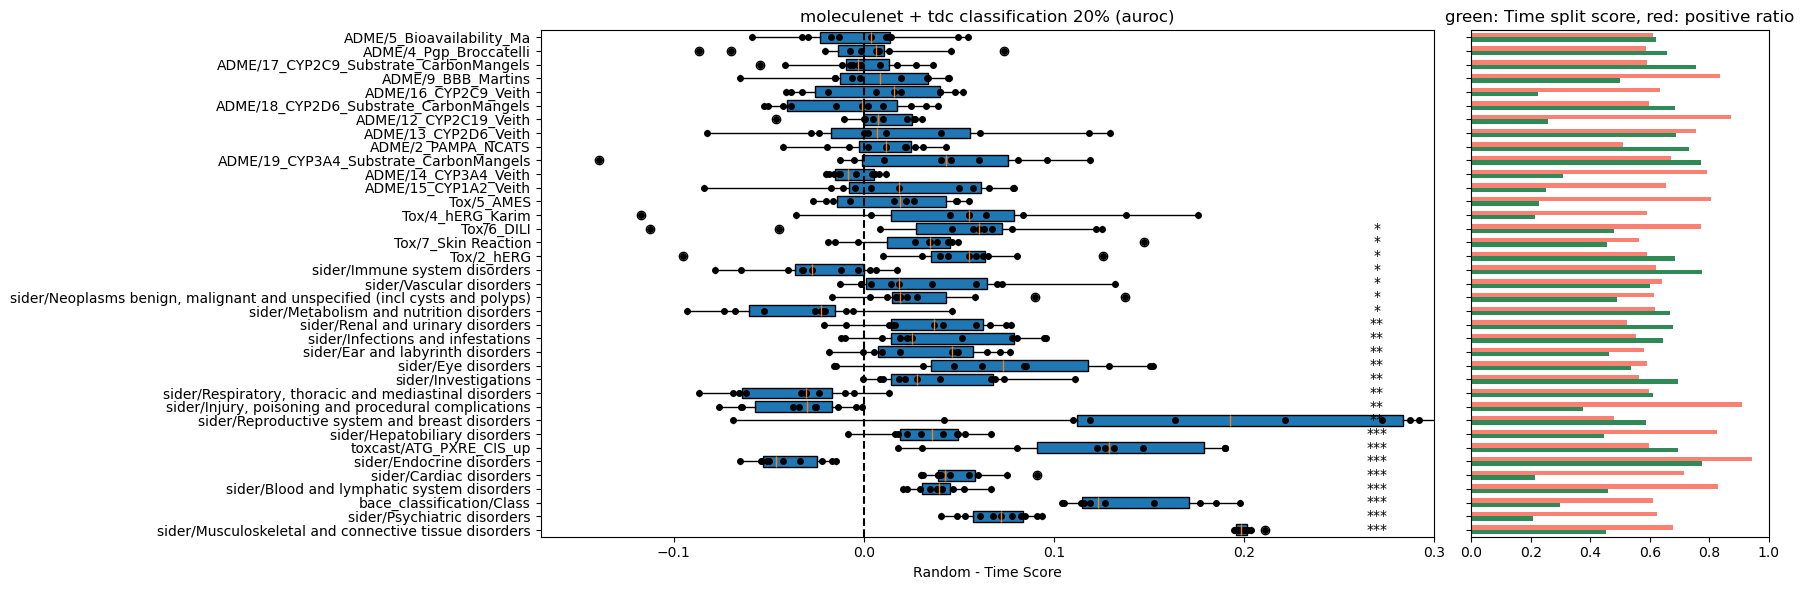

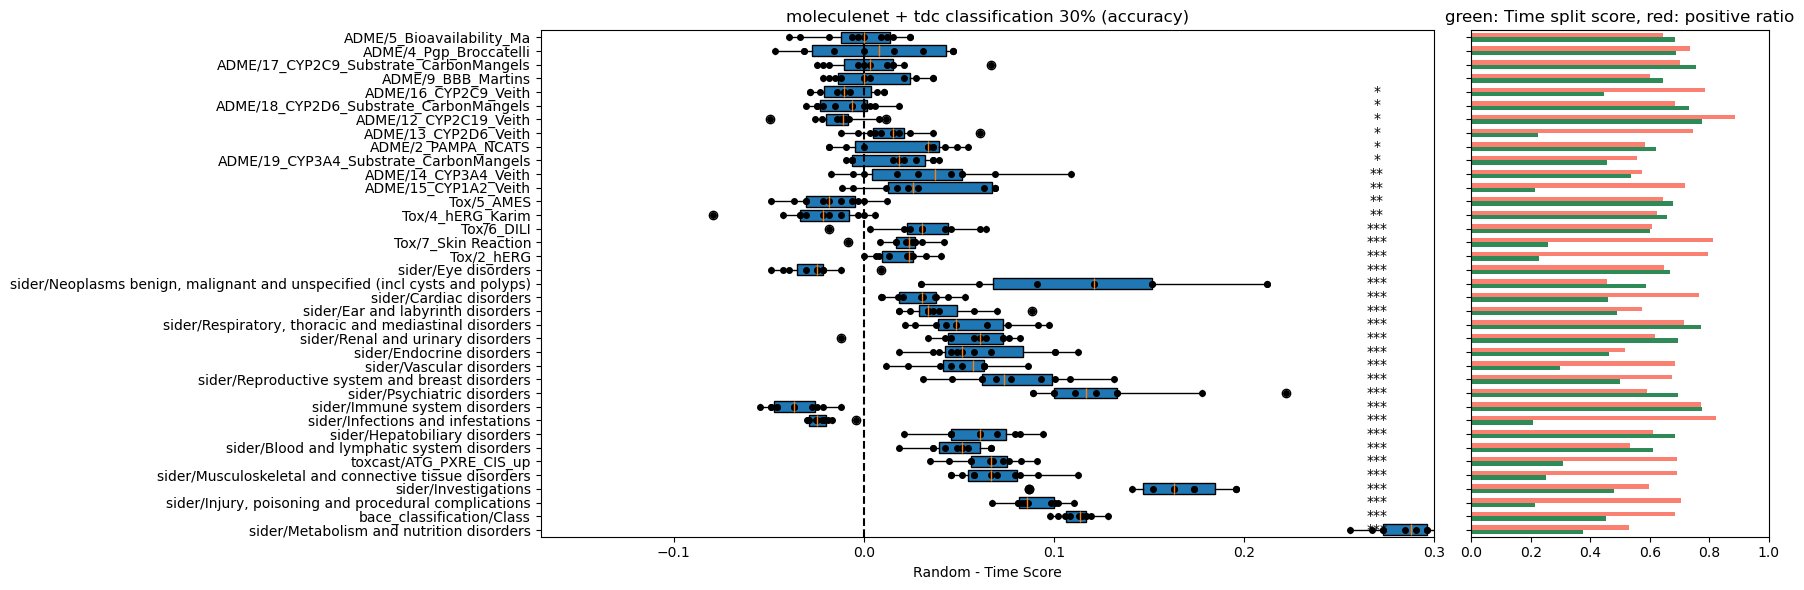

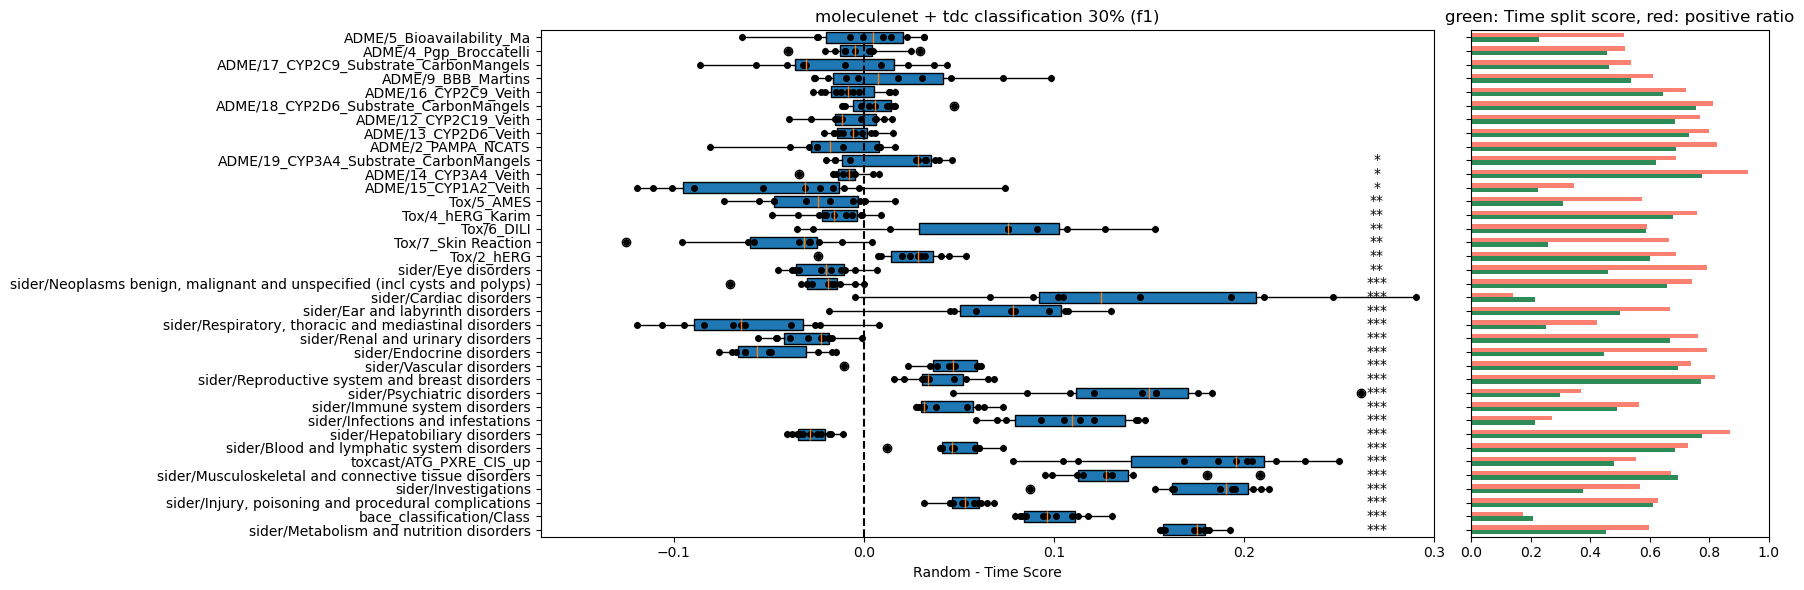

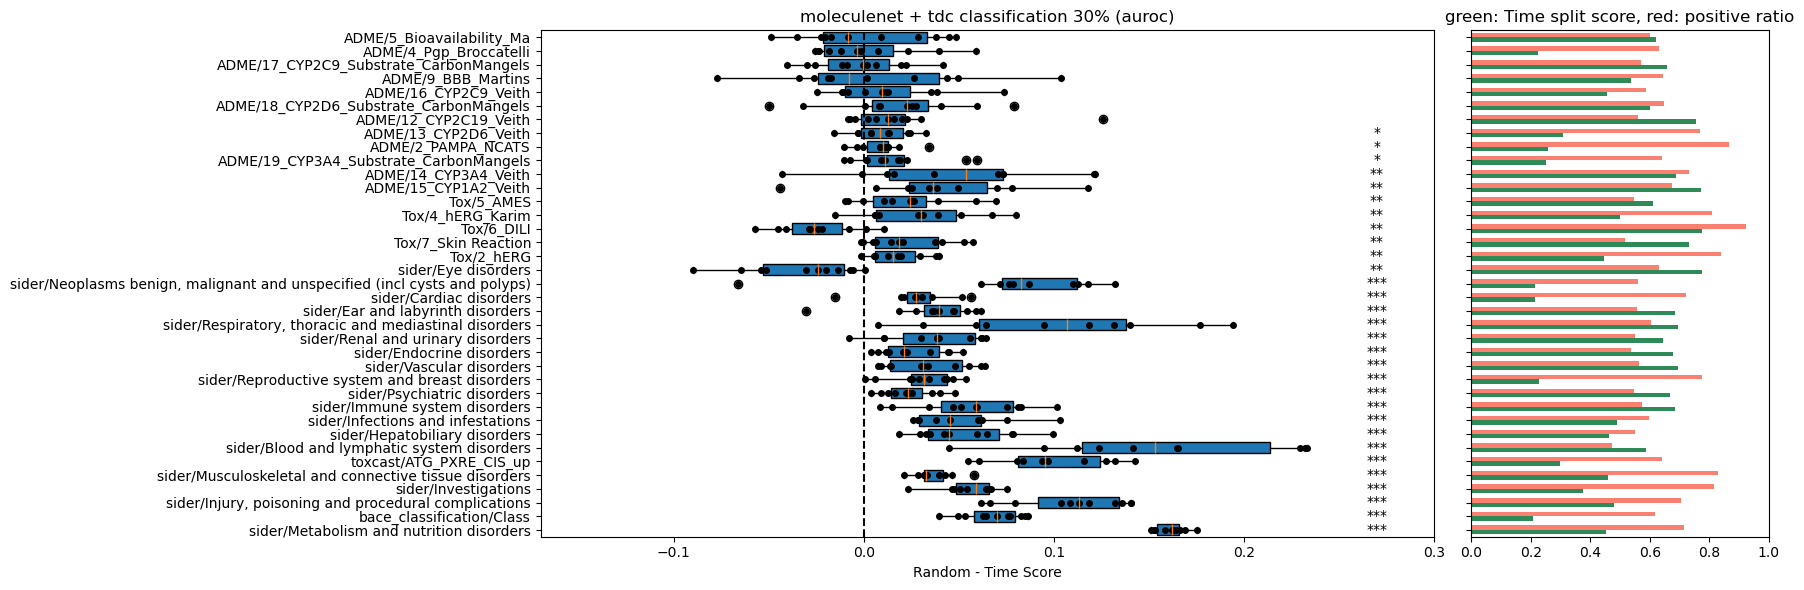

In [6]:
combined_scores = []

for key in ["20", "30"]:
    for use_score in ["accuracy", "f1", "auroc"]:

        if use_score == "accuracy":
            score_col = 2
        elif use_score == "f1": 
            score_col = 3
        elif use_score == "auroc": 
            score_col = 4
        else: 
            raise ValueError('Invalid score')

        use_paths = mn_results_paths

        anna = []
        scores = []
        col = []
        score_times = []
        po_ratios = []

        for i in range(len(use_paths)):
            if key not in use_paths[i]:
                continue
            df = pd.read_csv(use_paths[i], sep="\t", header=None)
            name = use_paths[i].replace("../../data/result/moleculenet_scores/", "").replace(f"_moleculenet_{key}%.tsv", "")
            for n in range(len(df)):
                name = df.iloc[n,0]
                if name not in task_names:
                    continue
                task = df.iloc[n,1]
                score = df.iloc[n,score_col]
                po_ratio = df.iloc[n,5]
                
                if po_ratio < 0.2 or po_ratio > 0.8:
                    continue 

                if df.iloc[n,1] == "time":
                    score_time = score
                    try:
                        col.append(scores)
                        anna.append(col)
                        score_times.append(score_time)
                        po_ratios.append(po_ratio)
                        scores = []
                    except:
                        pass
                    col = []
                    col.append(name)
                    continue
                else:
                    scores.append(score - score_time)
        col.append(scores)
        anna.append(col)

        p_values = []
        labels = []
        uses = []
        mu  = 0

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)


        use_path = f"../../data/result/tdc_scores/tdc_{key}%.tsv"
        df = pd.read_csv(use_path, sep="\t", header=None)
        anna = []
        scores = []
        col = []

        for i in range(len(df)):
            name = df.iloc[i,0]
            if name not in task_names:
                continue
            task = df.iloc[i,1]
            score = df.iloc[i,score_col]
            po_ratio = df.iloc[i,5]
            if po_ratio < 0.2 or po_ratio > 0.8:
                continue 

            if task == "time":
                score_time = score
                try:
                    col.append(scores)
                    anna.append(col)
                    score_times.append(score_time)
                    po_ratios.append(po_ratio)
                    scores = []
                except:
                    pass
                col = []
                col.append(name)
                continue
            else:
                scores.append(score - score_time)
        col.append(scores)
        anna.append(col)

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)

        tsv = []
        for i in range(len(labels)):
            tsv.append([labels[i], p_values[i], uses[i], score_times[i], po_ratios[i]])

        labels = []
        for i in range(len(tsv)):
            labels.append(tsv[i][0])

        sorted_data = sorted(tsv, key=lambda x: x[1])
        fig = plt.figure(figsize=(18, 6))
        gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
        ax1 = fig.add_subplot(gs[0]) 
        ax2 = fig.add_subplot(gs[1]) 

        title = f"moleculenet + tdc classification {key}% ({use_score})"
        width = 0.8
        xs = [i for i in range(len(labels))]
        l = labels

        for i in range(len(sorted_data)):
            use = sorted_data[i][2]
            label = sorted_data[i][0]
            p_value = sorted_data[i][1]
            position = xs[i]

            ax1.boxplot(use, widths=width, vert=False, patch_artist=True, tick_labels=[l[i]], positions=[position])
            ax1.plot(use, [position for n in range(len(use))], 'o', alpha=1, ms=4, color="black")

            if p_value < 0.001:
                star = '***'
            elif p_value < 0.01:
                star = '**'
            elif p_value < 0.05:
                star = '*'
            else:
                star = '' 

            if star:
                y_max = np.max(use)
                ax1.text(0.27, position - 0.5, star, fontsize=10, ha='center', va='bottom')

        ax1.set_title(title)
        ax1.set_xlim(-0.17, 0.3)
        ax1.set_xlabel("Random - Time Score")
        ax1.axvline(mu, color='black', linestyle='--', linewidth=1.5, label=f'Mean (mu) = {mu}')

        score_base = [item[3] for item in sorted_data]
        po_ratios = [item[4] for item in sorted_data]
        for i in range(len(score_base)):
            ax2.barh(xs[i]+(width*0.4/2), score_base[i], width*0.4, color='salmon')
            ax2.barh(xs[i]-(width*0.4/2), po_ratios[i], width*0.4, color='seagreen')
        ax2.set_yticks(xs)
        ax2.set_yticklabels([])
        ax2.set_xlim(0.0,1.0)
        ax2.set_ylim(ax1.get_ylim())
        ax2.set_xlabel("") 
        ax2.set_title("green: Time split score, red: positive ratio")  

        plt.tight_layout()
        plt.show()

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)

        z_scores = norm.ppf(1 - np.array(p_values))
        z_scores_sgn = []
        for i in range(len(z_scores)):
            if i in [3,15]:
                z_scores_sgn.append(-z_scores[i])
            else:
                z_scores_sgn.append(z_scores[i])

        z_combined = np.sum(z_scores_sgn) / np.sqrt(len(z_scores_sgn))
        p_combined = 1 - norm.cdf(z_combined)
        combined_scores.append([title, z_combined, p_combined])

pd.DataFrame(combined_scores).to_csv("../../data/result/combined_p_value_cls_2.csv", index=False)

In [7]:
combined_scores #合成Zスコア、統合P値

[['moleculenet + tdc classification 20% (accuracy)',
  np.float64(23.486936334360543),
  np.float64(0.0)],
 ['moleculenet + tdc classification 20% (f1)',
  np.float64(21.892128475617582),
  np.float64(0.0)],
 ['moleculenet + tdc classification 20% (auroc)',
  np.float64(18.31143711403301),
  np.float64(0.0)],
 ['moleculenet + tdc classification 30% (accuracy)',
  np.float64(24.519308998016744),
  np.float64(0.0)],
 ['moleculenet + tdc classification 30% (f1)',
  np.float64(22.078257530829674),
  np.float64(0.0)],
 ['moleculenet + tdc classification 30% (auroc)',
  np.float64(21.33263671081583),
  np.float64(0.0)]]

# run classification task (0.1 <= positive ratio <= 0.9)

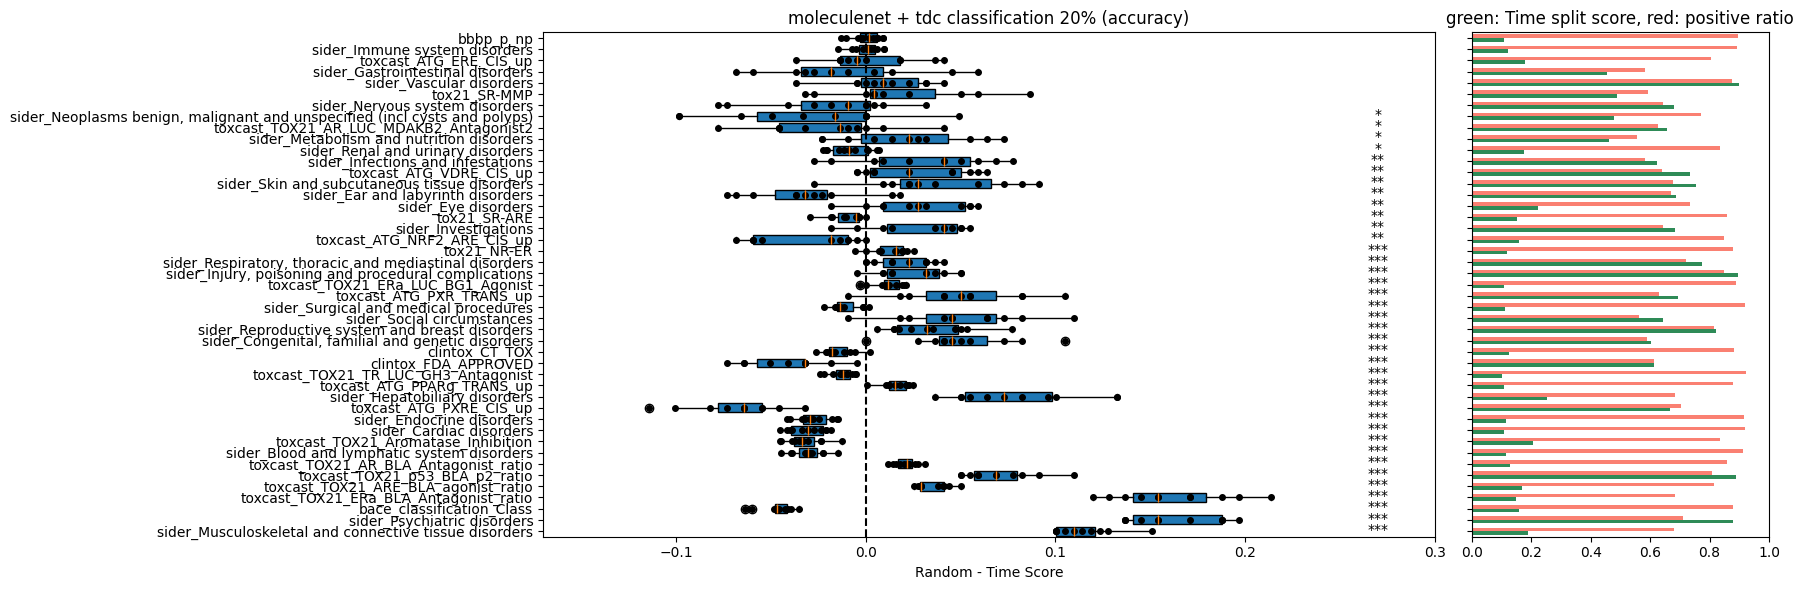

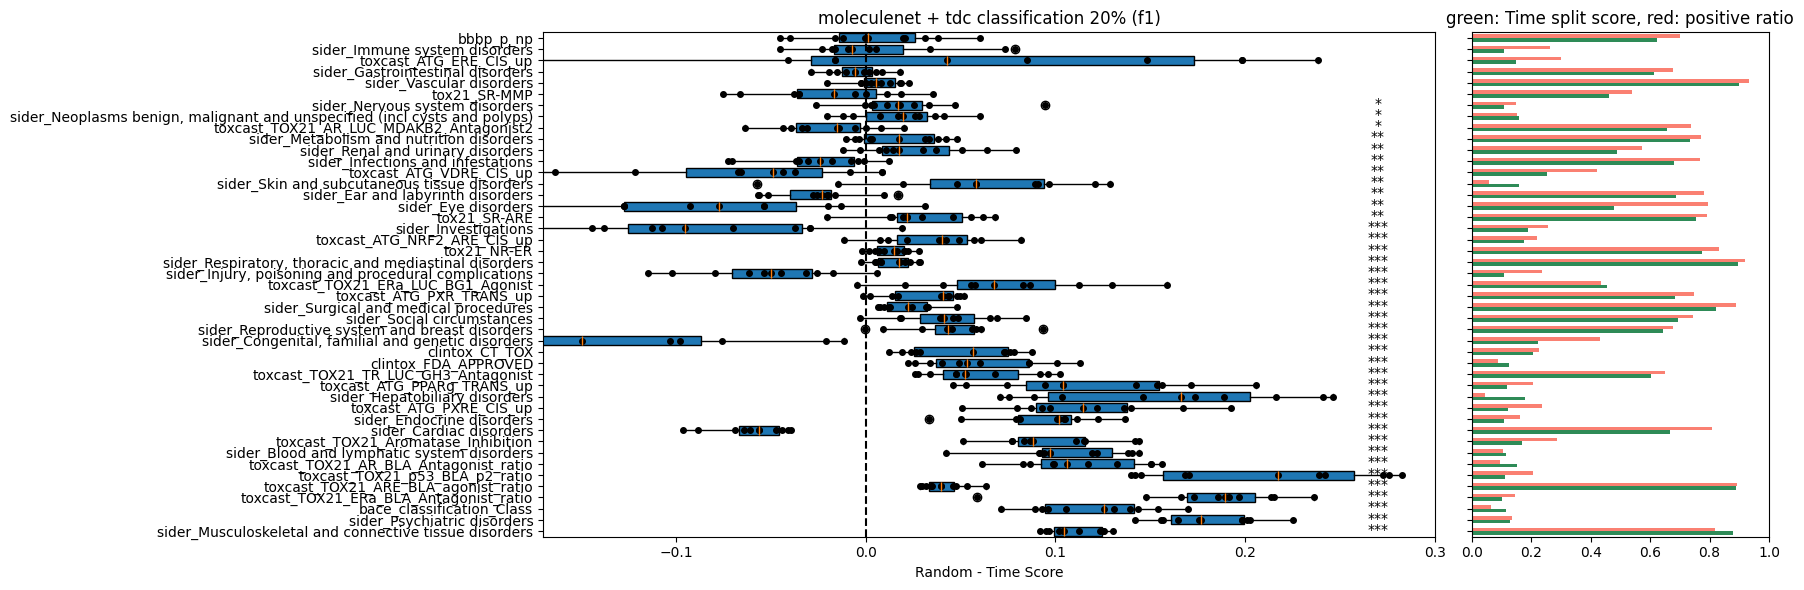

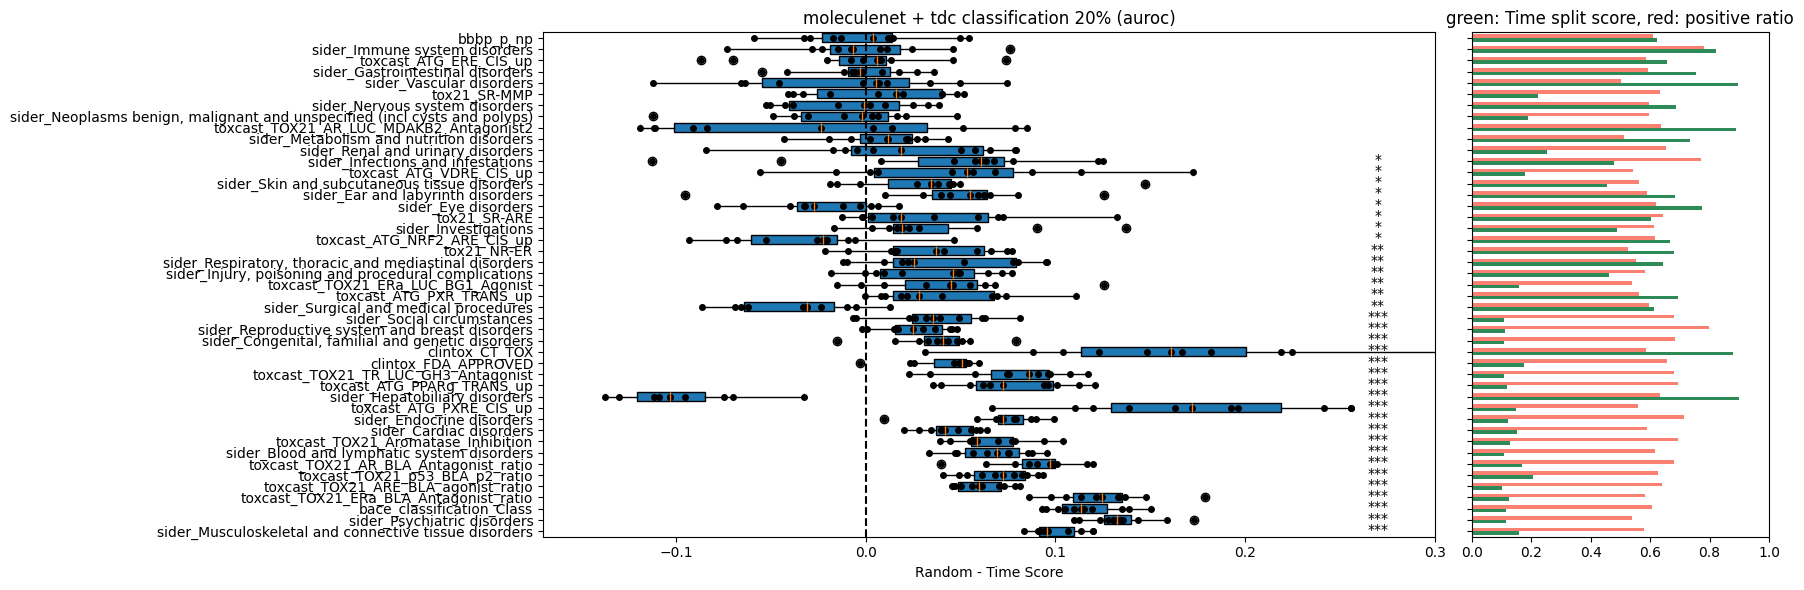

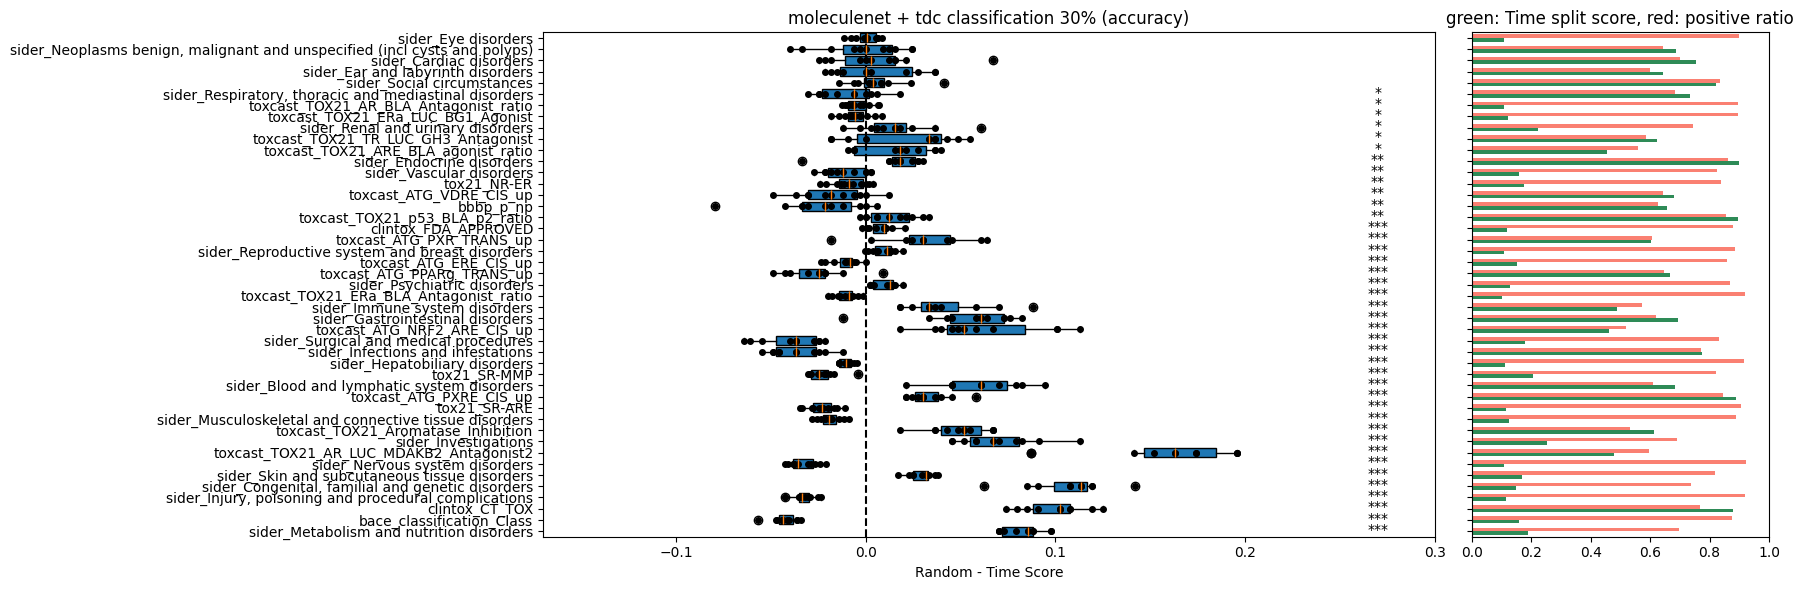

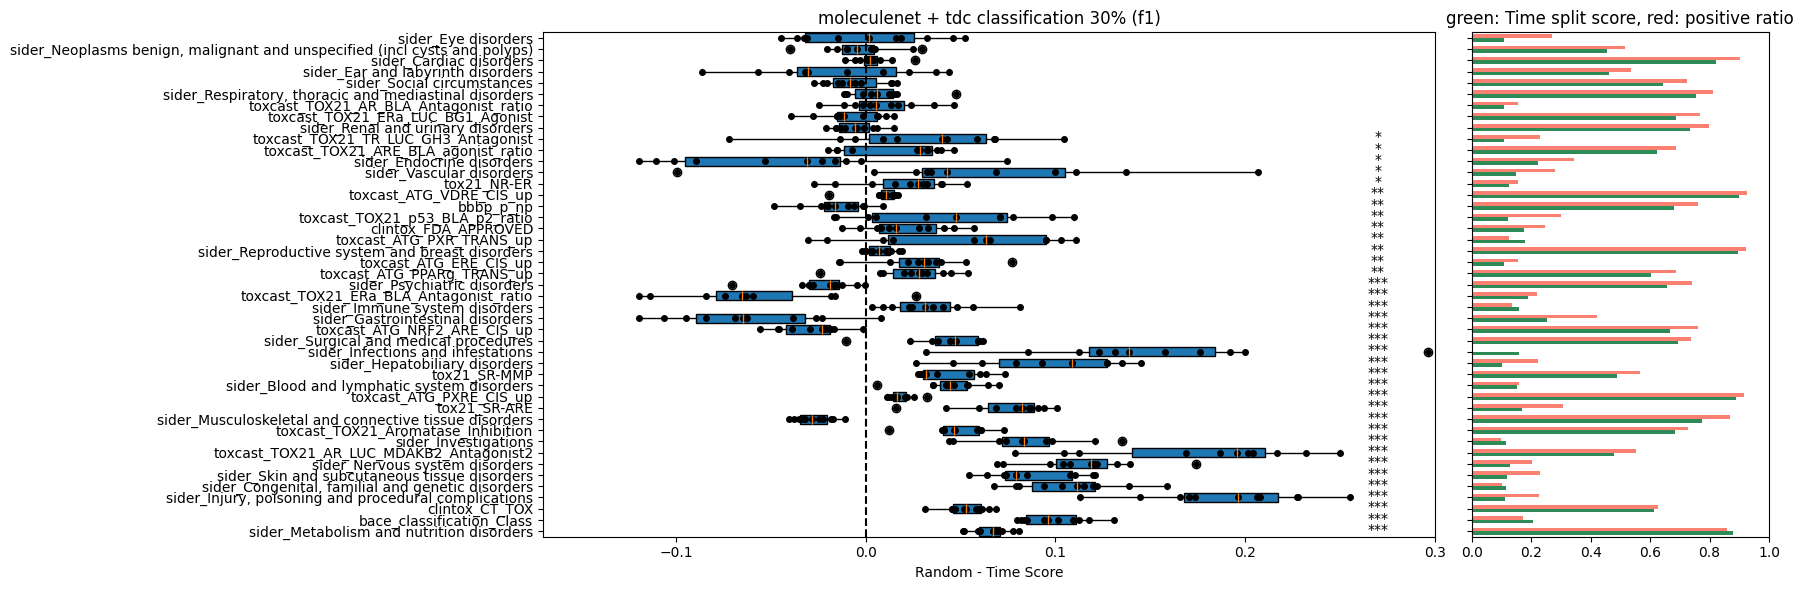

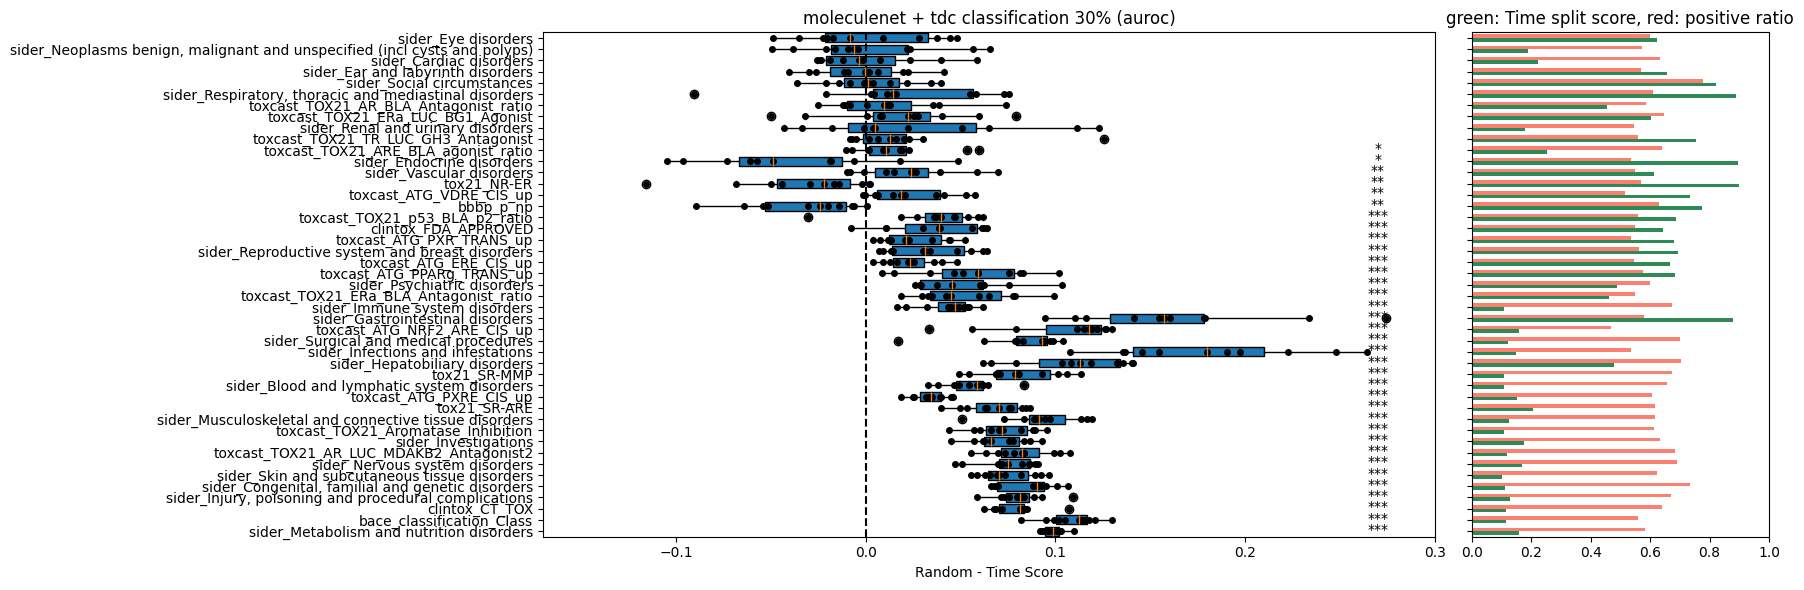

In [33]:
combined_scores = []

for key in ["20", "30"]:
    for use_score in ["accuracy", "f1", "auroc"]:

        if use_score == "accuracy":
            score_col = 2
        elif use_score == "f1": 
            score_col = 3
        elif use_score == "auroc": 
            score_col = 4
        else: 
            raise ValueError('Invalid score')

        use_paths = mn_results_paths

        anna = []
        scores = []
        col = []
        score_times = []
        po_ratios = []

        for i in range(len(use_paths)):
            if key not in use_paths[i]:
                continue
            df = pd.read_csv(use_paths[i], sep="\t", header=None)
            name = use_paths[i].replace("../../data/result/moleculenet_scores/", "").replace(f"_moleculenet_{key}%.tsv", "")
            for n in range(len(df)):
                task = df.iloc[n,1]
                score = df.iloc[n,score_col]
                po_ratio = df.iloc[n,5]
                
                if po_ratio < 0.1 or po_ratio > 0.9:
                    continue 

                if df.iloc[n,1] == "time":
                    score_time = score
                    try:
                        col.append(scores)
                        anna.append(col)
                        score_times.append(score_time)
                        po_ratios.append(po_ratio)
                        scores = []
                    except:
                        pass
                    col = []
                    col.append(name)
                    continue
                else:
                    scores.append(score - score_time)
        col.append(scores)
        anna.append(col)

        p_values = []
        labels = []
        uses = []
        mu  = 0

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)


        use_path = f"../../data/result/tdc_scores/tdc_{key}%.tsv"
        df = pd.read_csv(use_path, sep="\t", header=None)
        anna = []
        scores = []
        col = []

        for i in range(len(df)):
            name = df.iloc[i,0]
            task = df.iloc[i,1]
            score = df.iloc[i,score_col]
            po_ratio = df.iloc[n,5]
            if po_ratio < 0.1 or po_ratio > 0.9:
                continue 

            if task == "time":
                score_time = score
                try:
                    col.append(scores)
                    anna.append(col)
                    score_times.append(score_time)
                    po_ratios.append(po_ratio)
                    scores = []
                except:
                    pass
                col = []
                col.append(name)
                continue
            else:
                scores.append(score - score_time)
        col.append(scores)
        anna.append(col)

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)

        tsv = []
        for i in range(len(labels)):
            tsv.append([labels[i], p_values[i], uses[i], score_times[i], po_ratios[i]])

        labels = []
        for i in range(len(tsv)):
            labels.append(tsv[i][0])

        sorted_data = sorted(tsv, key=lambda x: x[1])
        fig = plt.figure(figsize=(18, 6))
        gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
        ax1 = fig.add_subplot(gs[0]) 
        ax2 = fig.add_subplot(gs[1]) 

        title = f"moleculenet + tdc classification {key}% ({use_score})"
        width = 0.8
        xs = [i for i in range(len(labels))]
        l = labels

        for i in range(len(sorted_data)):
            use = sorted_data[i][2]
            label = sorted_data[i][0]
            p_value = sorted_data[i][1]
            position = xs[i]

            ax1.boxplot(use, widths=width, vert=False, patch_artist=True, tick_labels=[l[i]], positions=[position])
            ax1.plot(use, [position for n in range(len(use))], 'o', alpha=1, ms=4, color="black")

            if p_value < 0.001:
                star = '***'
            elif p_value < 0.01:
                star = '**'
            elif p_value < 0.05:
                star = '*'
            else:
                star = '' 

            if star:
                y_max = np.max(use)
                ax1.text(0.27, position - 0.5, star, fontsize=10, ha='center', va='bottom')

        ax1.set_title(title)
        ax1.set_xlim(-0.17, 0.3)
        ax1.set_xlabel("Random - Time Score")
        ax1.axvline(mu, color='black', linestyle='--', linewidth=1.5, label=f'Mean (mu) = {mu}')

        score_base = [item[3] for item in sorted_data]
        po_ratios = [item[4] for item in sorted_data]
        for i in range(len(score_base)):
            ax2.barh(xs[i]+(width*0.4/2), score_base[i], width*0.4, color='salmon')
            ax2.barh(xs[i]-(width*0.4/2), po_ratios[i], width*0.4, color='seagreen')
        ax2.set_yticks(xs)
        ax2.set_yticklabels([])
        ax2.set_xlim(0.0,1.0)
        ax2.set_ylim(ax1.get_ylim())
        ax2.set_xlabel("") 
        ax2.set_title("green: Time split score, red: positive ratio")  

        plt.tight_layout()
        plt.show()

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)

        z_scores = norm.ppf(1 - np.array(p_values))
        z_scores_sgn = []
        for i in range(len(z_scores)):
            if i in [3,15]:
                z_scores_sgn.append(-z_scores[i])
            else:
                z_scores_sgn.append(z_scores[i])

        z_combined = np.sum(z_scores_sgn) / np.sqrt(len(z_scores_sgn))
        p_combined = 1 - norm.cdf(z_combined)
        combined_scores.append([title, z_combined, p_combined])

pd.DataFrame(combined_scores).to_csv("../../data/result/combined_p_value_cls_3.csv", index=False)

In [34]:
combined_scores

[['moleculenet + tdc classification 20% (accuracy)',
  np.float64(19.512066140304643),
  np.float64(0.0)],
 ['moleculenet + tdc classification 20% (f1)',
  np.float64(19.864486053834124),
  np.float64(0.0)],
 ['moleculenet + tdc classification 20% (auroc)',
  np.float64(18.123420337707163),
  np.float64(0.0)],
 ['moleculenet + tdc classification 30% (accuracy)',
  np.float64(22.711798663763062),
  np.float64(0.0)],
 ['moleculenet + tdc classification 30% (f1)',
  np.float64(20.362743691965996),
  np.float64(0.0)],
 ['moleculenet + tdc classification 30% (auroc)',
  np.float64(23.111327912657476),
  np.float64(0.0)]]

# run regression task (0.1 <= positive ratio <= 0.9)
not done molculenet regression tasks

In [36]:
task_names = []
for i in range(len(df_mn_details)):
    task = f"{df_mn_details.iloc[i,0]}/{df_mn_details.iloc[i,1]}"
    if df_mn_details.iloc[i,5] == 10000000:
        task_names.append(task)
for i in range(len(df_tdc_details)):
    task = f"{df_tdc_details.iloc[i,0]}/{df_tdc_details.iloc[i,1]}"
    if df_tdc_details.iloc[i,5] == 10000000:
        task_names.append(task)

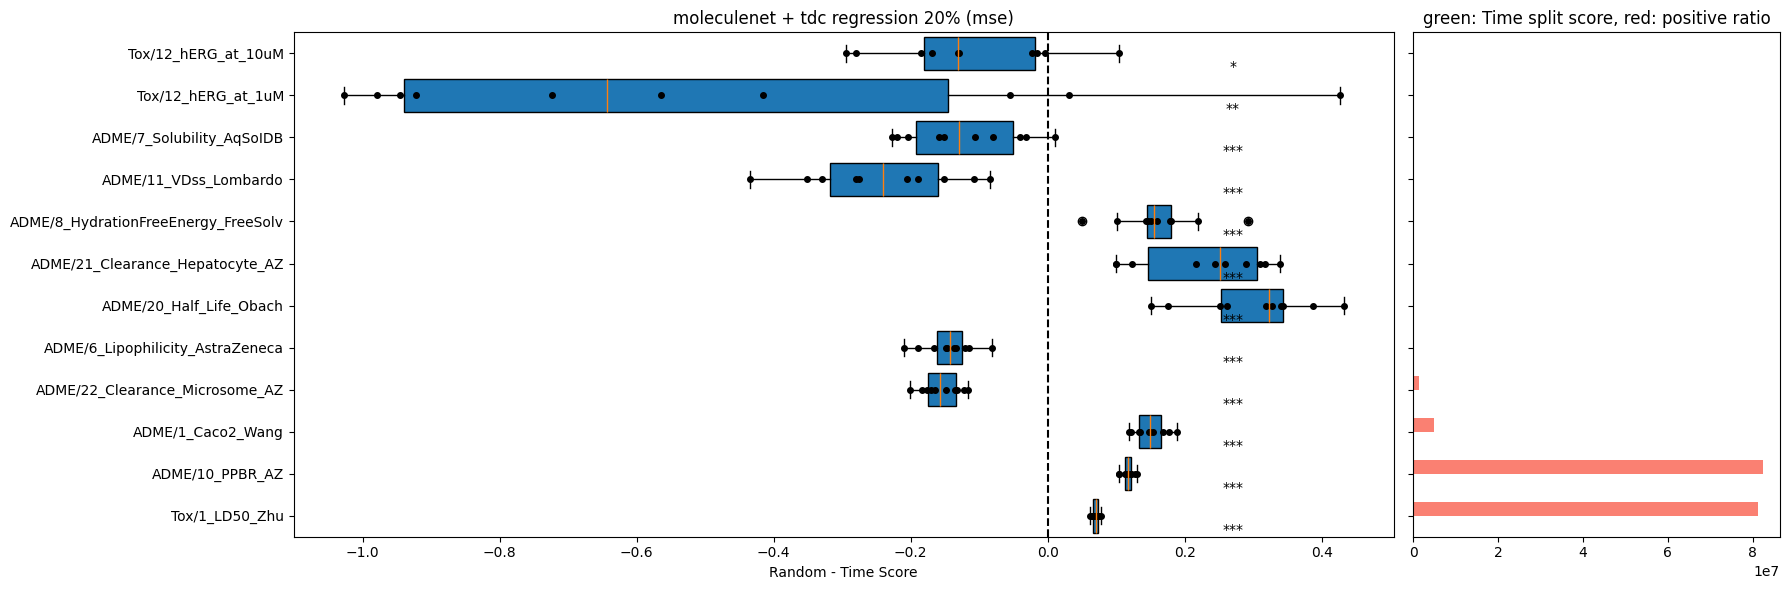

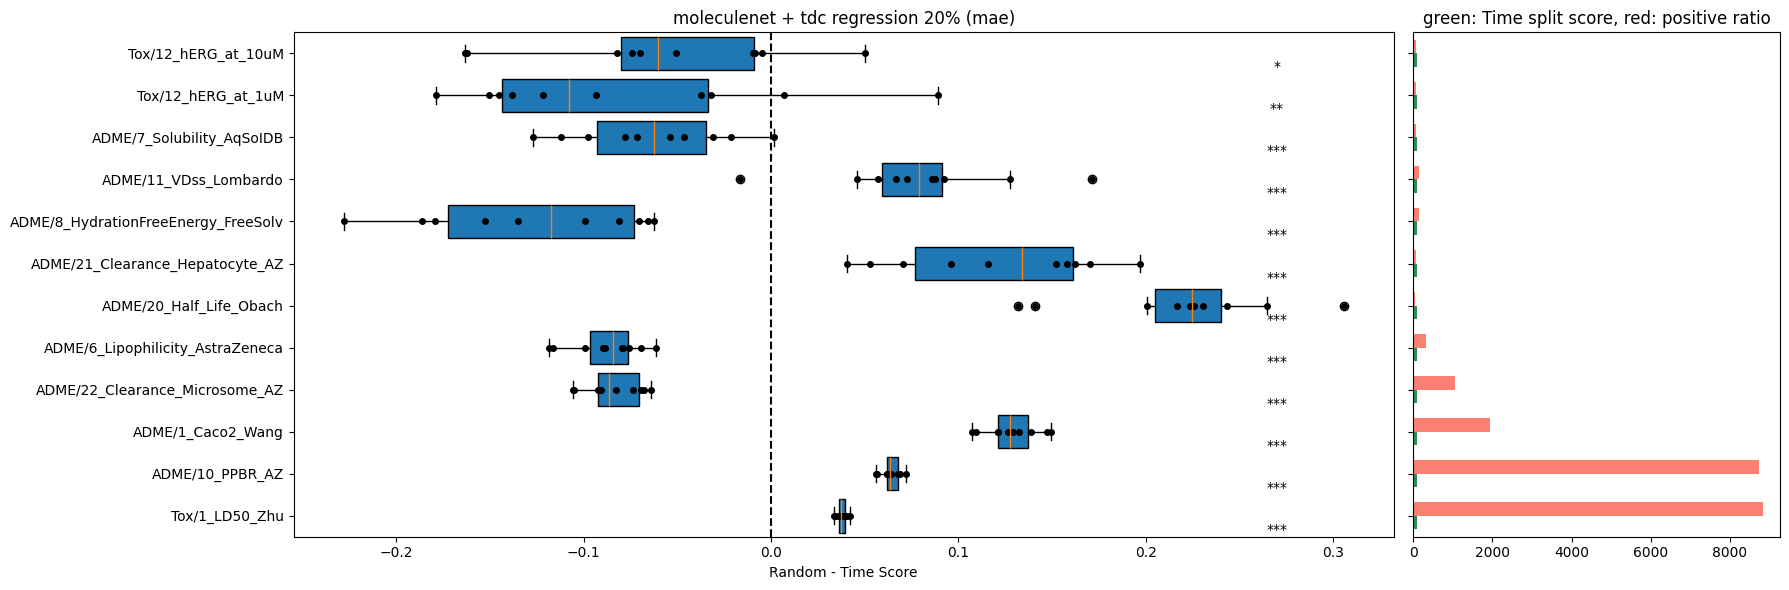

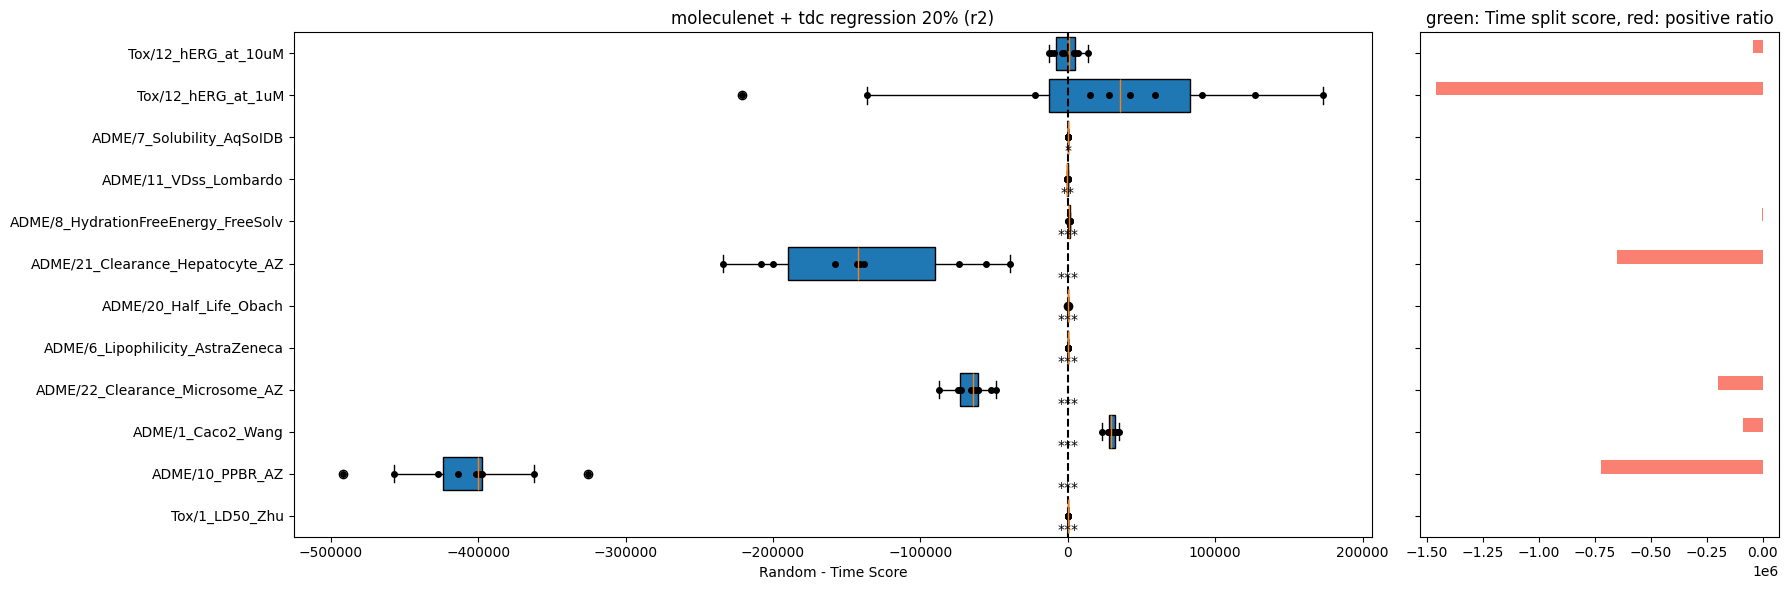

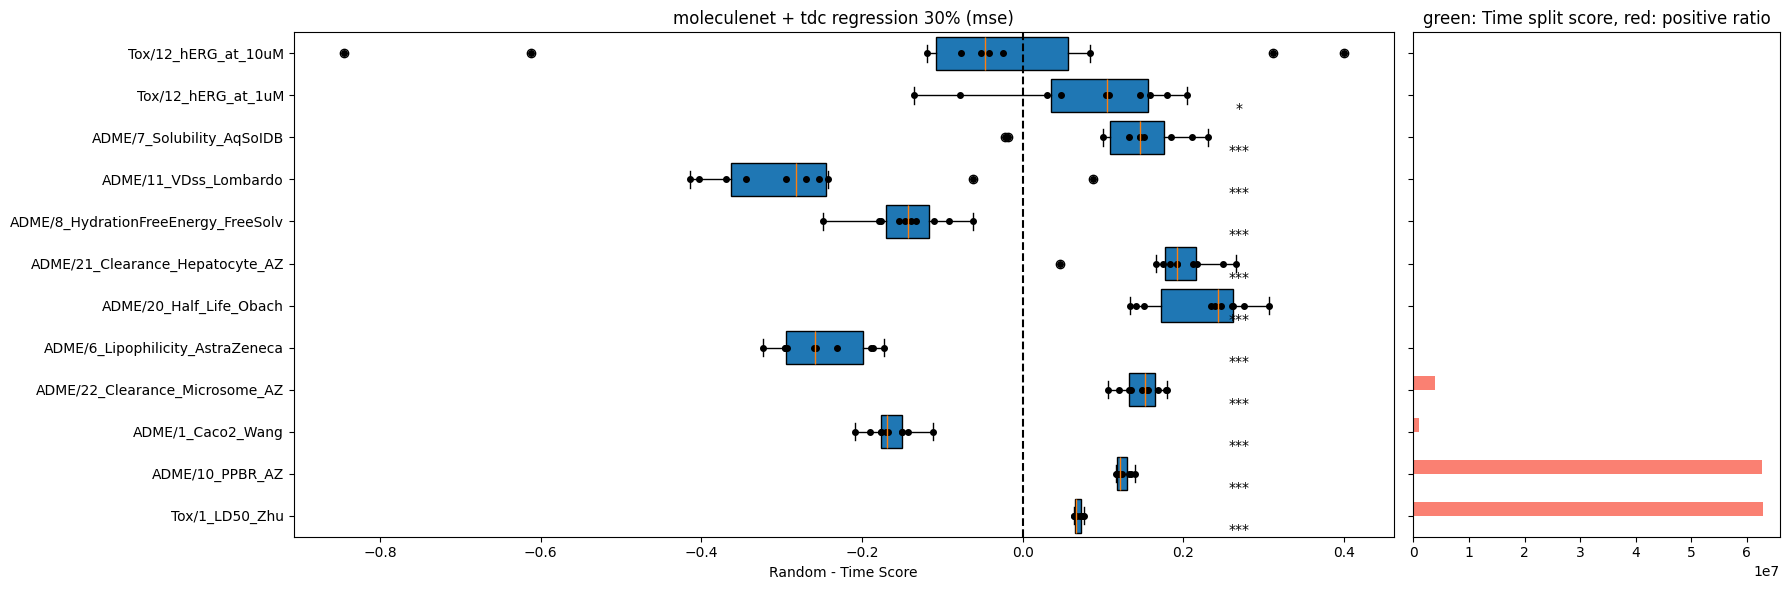

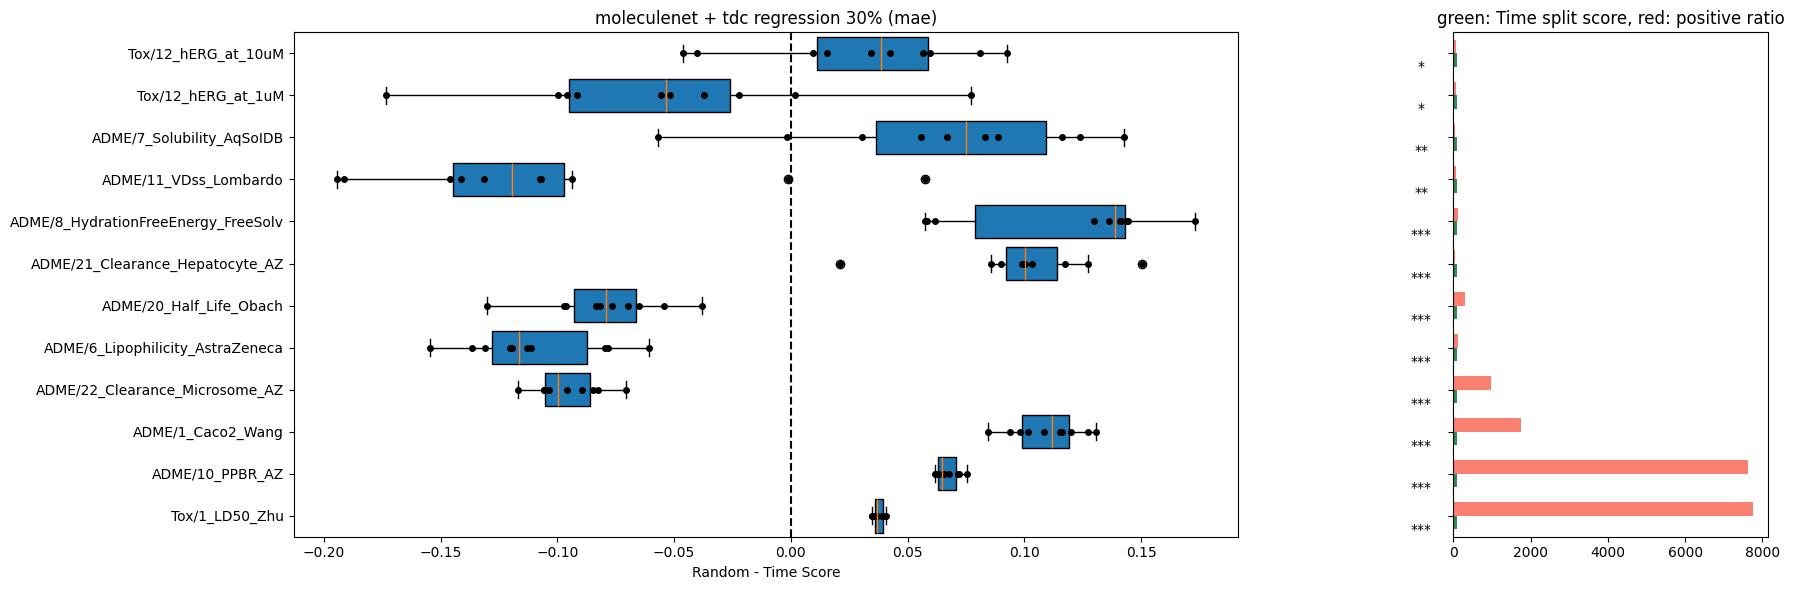

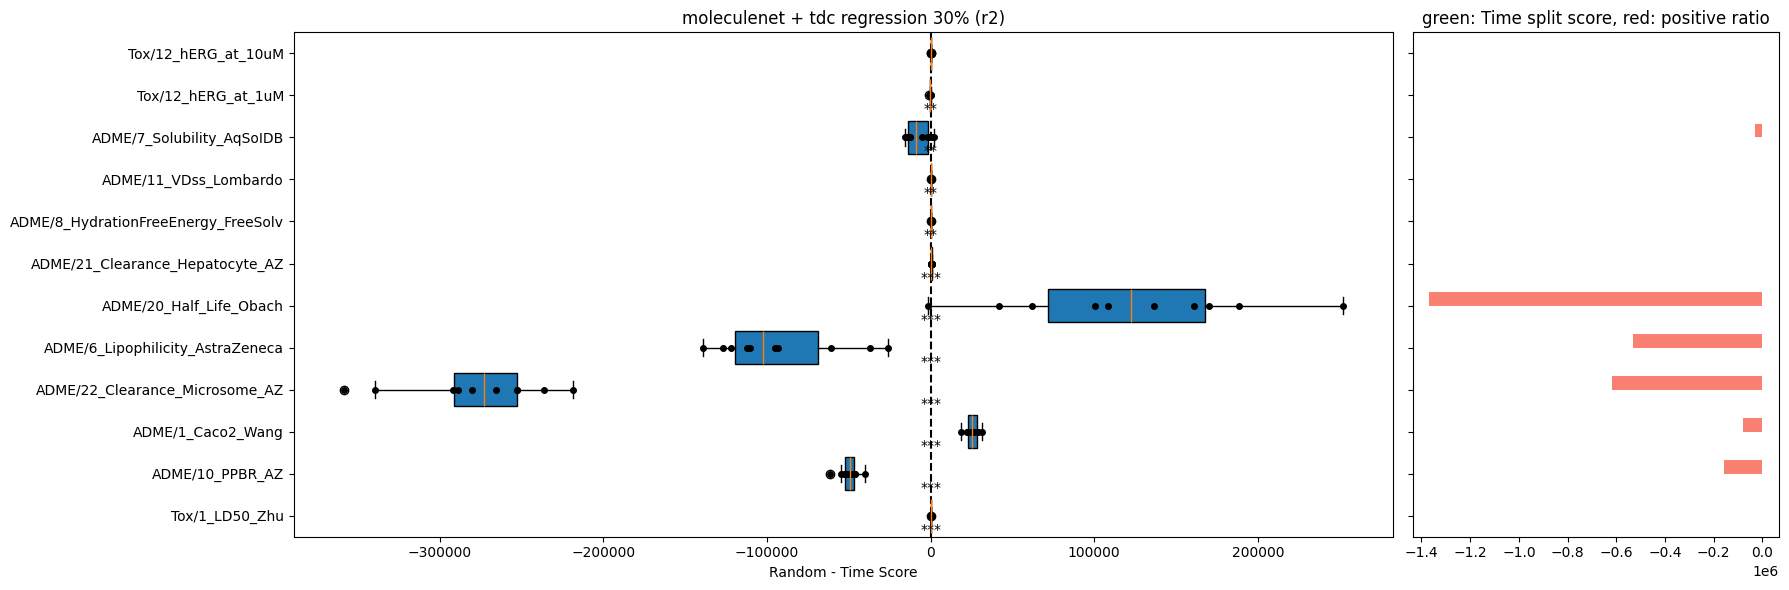

In [49]:
combined_scores = []

for key in ["20", "30"]:
    for use_score in ["mse", "mae", "r2"]:

        if use_score == "mse":
            score_col = 3
        elif use_score == "mae":
            score_col = 4
        elif use_score == "r2":
            score_col = 2
        else:
            raise ValueError('Invalid score')

        use_paths = mn_results_paths

        anna = []
        scores = []
        col = []
        score_times = []

        for i in range(len(use_paths)):
            if key not in use_paths[i]:
                continue
            df = pd.read_csv(use_paths[i], sep="\t", header=None)
            name = use_paths[i].replace("../../data/result/moleculenet_scores/", "").replace(f"_moleculenet_{key}%.tsv", "")
            for n in range(len(df)):
                name = df.iloc[n, 0]
                if name not in task_names:
                    continue
                task = df.iloc[n, 1]
                score = df.iloc[n, score_col]

                if task == "time":
                    score_time = score
                    try:
                        col.append(scores)
                        anna.append(col)
                        score_times.append(score_time)
                        scores = []
                    except:
                        pass
                    col = []
                    col.append(name)
                    continue
                else:
                    if use_score in ["mse", "mae"]:
                        scores.append((score - score_time) / score)
                    else:
                        scores.append(score - score_time)
        col.append(scores)
        anna.append(col)

        p_values = []
        labels = []
        uses = []
        mu  = 0

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)


        use_path = f"../../data/result/tdc_scores/tdc_reg_{key}%.tsv"
        df = pd.read_csv(use_path, sep="\t", header=None)
        anna = []
        scores = []
        col = []

        for i in range(len(df)):
            name = df.iloc[i,0]
            if name not in task_names:
                continue
            task = df.iloc[i,1]
            score = df.iloc[i,score_col]
            po_ratio = df.iloc[n,5]

            if task == "time":
                score_time = score
                try:
                    col.append(scores)
                    anna.append(col)
                    score_times.append(score_time)
                    po_ratios.append(po_ratio)
                    scores = []
                except:
                    pass
                col = []
                col.append(name)
                continue
            else:
                if use_score in ["mse", "mae"]:
                    scores.append((score - score_time) / score)
                else:
                    scores.append(score - score_time)
        col.append(scores)
        anna.append(col)

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)

        tsv = []
        for i in range(len(labels)):
            tsv.append([labels[i], p_values[i], uses[i], score_times[i], po_ratios[i]])

        labels = []
        for i in range(len(tsv)):
            labels.append(tsv[i][0])

        sorted_data = sorted(tsv, key=lambda x: x[1])
        fig = plt.figure(figsize=(18, 6))
        gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
        ax1 = fig.add_subplot(gs[0]) 
        ax2 = fig.add_subplot(gs[1]) 

        title = f"moleculenet + tdc regression {key}% ({use_score})"
        width = 0.8
        xs = [i for i in range(len(labels))]
        l = labels

        for i in range(len(sorted_data)):
            use = sorted_data[i][2]
            label = sorted_data[i][0]
            p_value = sorted_data[i][1]
            position = xs[i]

            ax1.boxplot(use, widths=width, vert=False, patch_artist=True, tick_labels=[l[i]], positions=[position])
            ax1.plot(use, [position for n in range(len(use))], 'o', alpha=1, ms=4, color="black")

            if p_value < 0.001:
                star = '***'
            elif p_value < 0.01:
                star = '**'
            elif p_value < 0.05:
                star = '*'
            else:
                star = '' 

            if star:
                y_max = np.max(use)
                ax1.text(0.27, position - 0.5, star, fontsize=10, ha='center', va='bottom')

        ax1.set_title(title)
        # ax1.set_xlim(-0.17, 0.3)
        ax1.set_xlabel("Random - Time Score")
        ax1.axvline(mu, color='black', linestyle='--', linewidth=1.5, label=f'Mean (mu) = {mu}')

        score_base = [item[3] for item in sorted_data]
        po_ratios = [item[4] for item in sorted_data]
        for i in range(len(score_base)):
            ax2.barh(xs[i]+(width*0.4/2), score_base[i], width*0.4, color='salmon')
            ax2.barh(xs[i]-(width*0.4/2), po_ratios[i], width*0.4, color='seagreen')
        ax2.set_yticks(xs)
        ax2.set_yticklabels([])
        # ax2.set_xlim(0.0,1.0)
        ax2.set_ylim(ax1.get_ylim())
        ax2.set_xlabel("") 
        ax2.set_title("green: Time split score, red: positive ratio")  

        plt.tight_layout()
        plt.show()

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)

        z_scores = norm.ppf(1 - np.array(p_values))
        z_scores_sgn = []
        for i in range(len(z_scores)):
            if i in [3,15]:
                z_scores_sgn.append(-z_scores[i])
            else:
                z_scores_sgn.append(z_scores[i])

        z_combined = np.sum(z_scores_sgn) / np.sqrt(len(z_scores_sgn))
        p_combined = 1 - norm.cdf(z_combined)
        combined_scores.append([title, z_combined, p_combined])

pd.DataFrame(combined_scores).to_csv("../../data/result/combined_p_value_reg_3.csv", index=False)

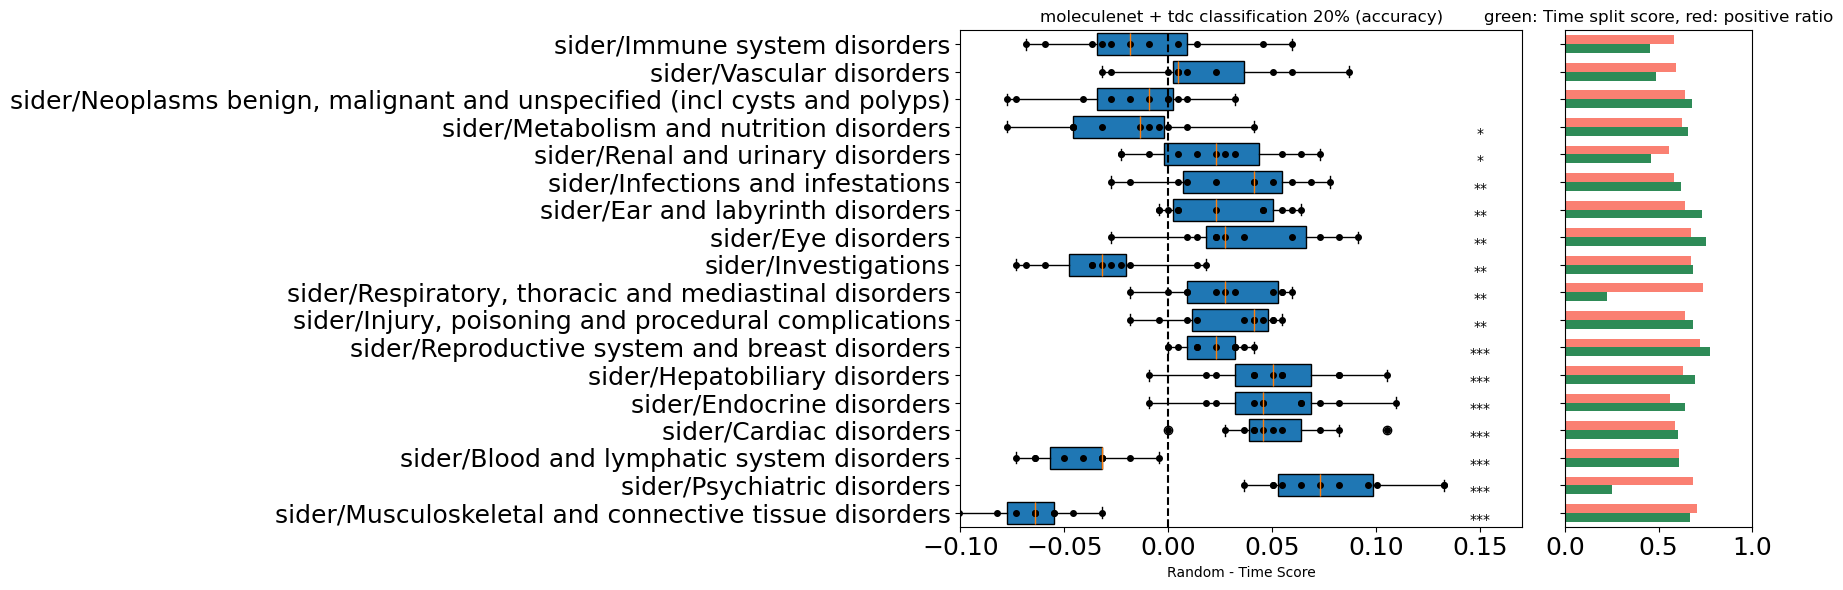

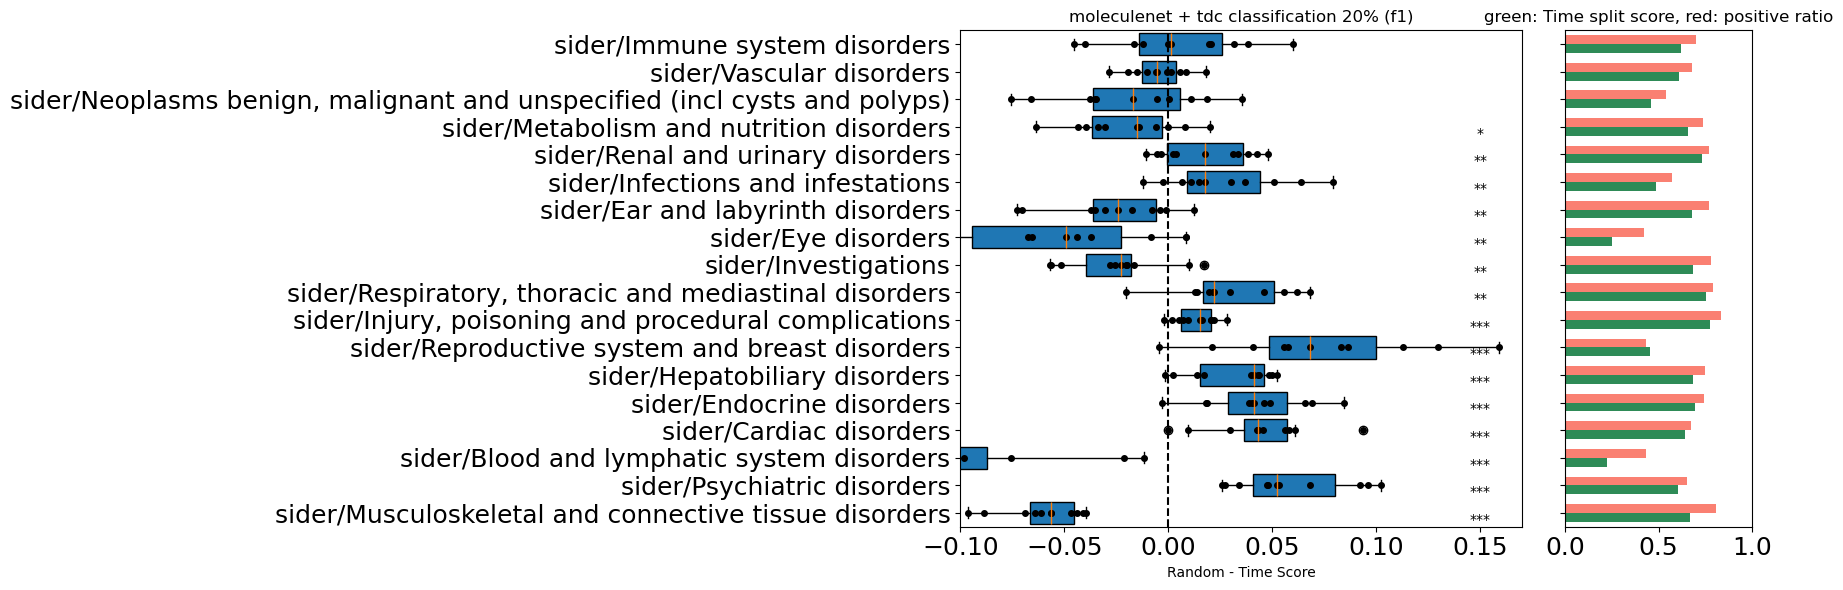

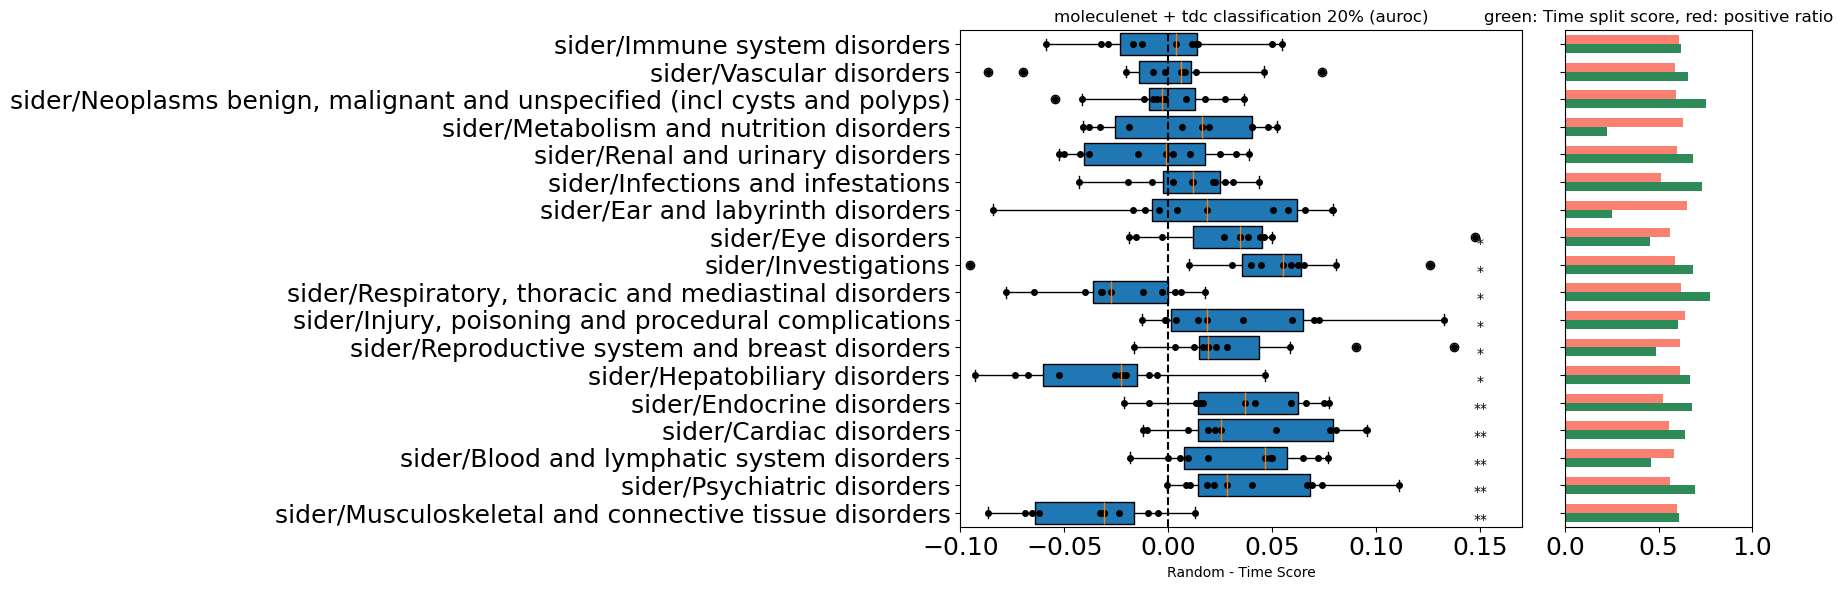

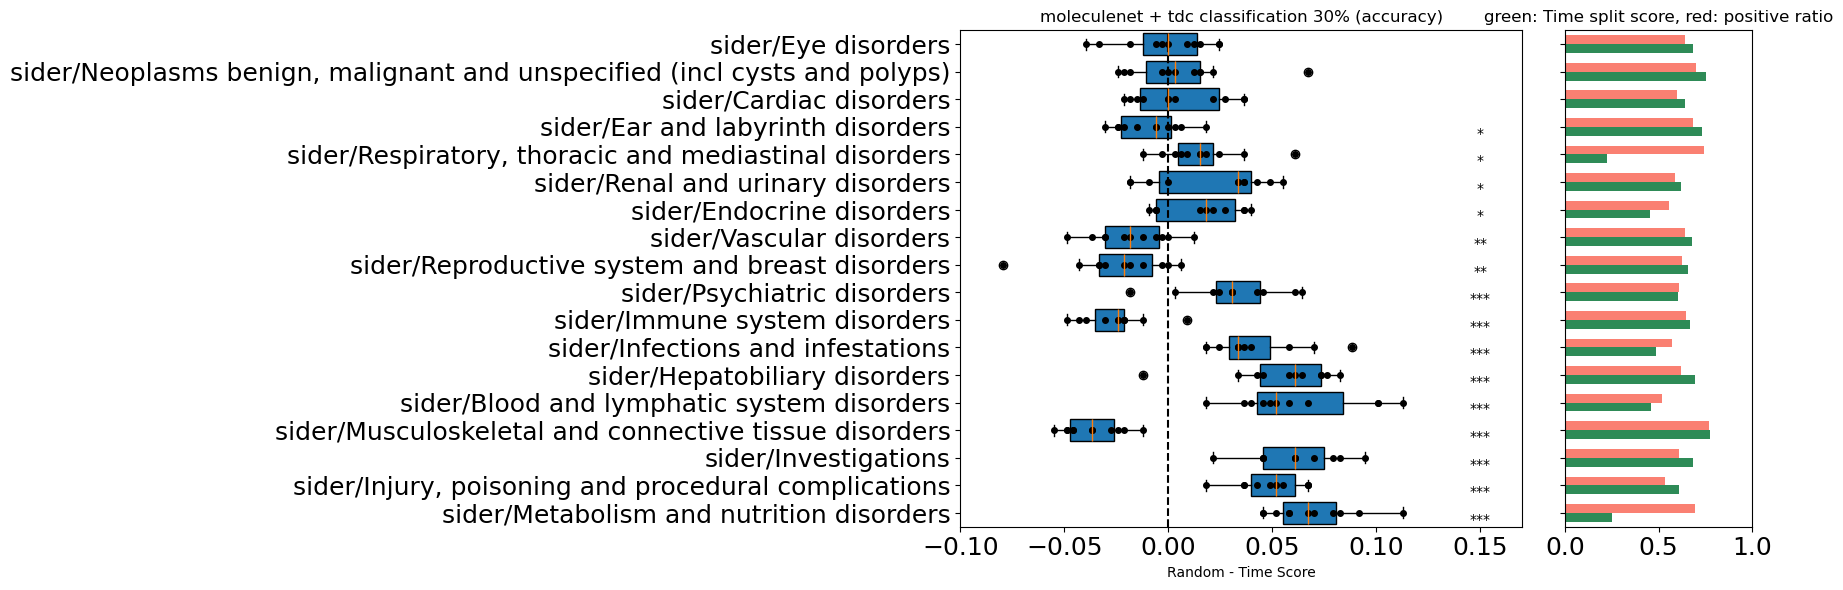

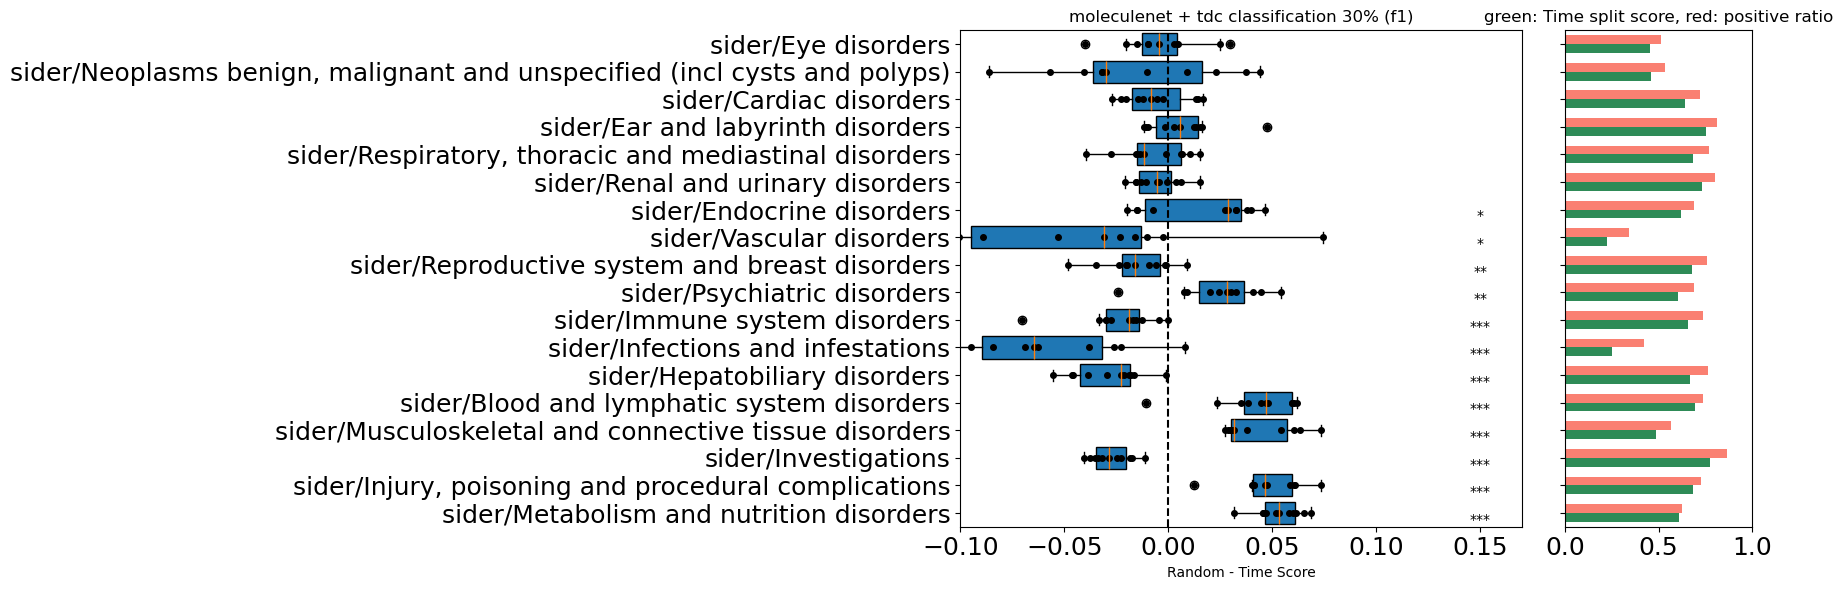

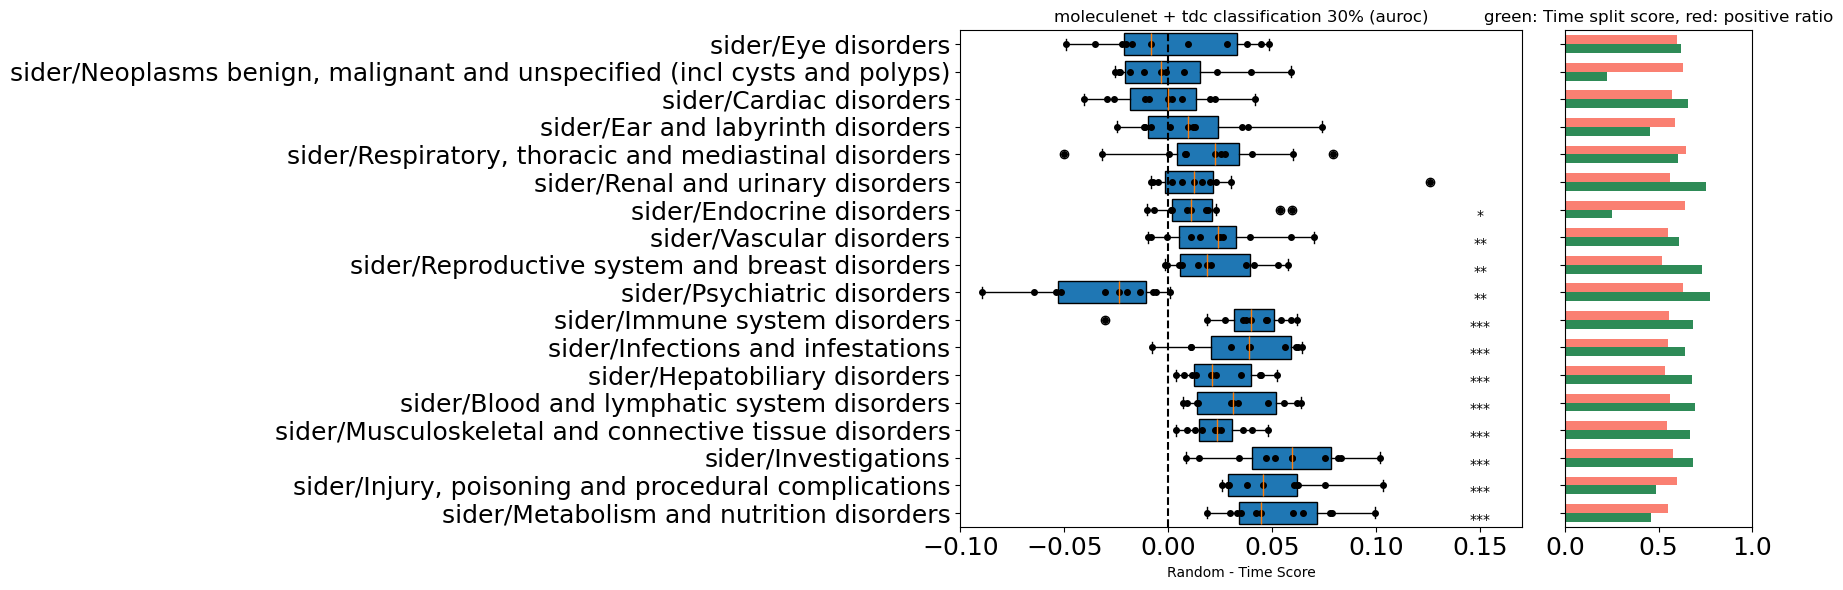

In [11]:
for key in ["20", "30"]:
    for use_score in ["accuracy", "f1", "auroc"]:

        if use_score == "accuracy":
            score_col = 2
        elif use_score == "f1": 
            score_col = 3
        elif use_score == "auroc": 
            score_col = 4
        else: 
            raise ValueError('Invalid score')

        use_paths = mn_results_paths

        anna = []
        scores = []
        col = []
        score_times = []
        po_ratios = []

        for i in range(len(use_paths)):
            if key not in use_paths[i]:
                continue
            if "sider" not in use_paths[i]:
                continue
            df = pd.read_csv(use_paths[i], sep="\t", header=None)
            name = use_paths[i].replace("../../data/result/moleculenet_scores/", "").replace(f"_moleculenet_{key}%.tsv", "")
            for n in range(len(df)):
                name = df.iloc[n,0]
                if name not in task_names:
                    continue
                task = df.iloc[n,1]
                score = df.iloc[n,score_col]
                po_ratio = df.iloc[n,5]
                
                if po_ratio < 0.2 or po_ratio > 0.8:
                    continue 

                if df.iloc[n,1] == "time":
                    score_time = score
                    try:
                        col.append(scores)
                        anna.append(col)
                        score_times.append(score_time)
                        po_ratios.append(po_ratio)
                        scores = []
                    except:
                        pass
                    col = []
                    col.append(name)
                    continue
                else:
                    scores.append(score - score_time)
        col.append(scores)
        anna.append(col)

        p_values = []
        labels = []
        uses = []
        mu  = 0

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)


        use_path = f"../../data/result/tdc_scores/tdc_{key}%.tsv"
        df = pd.read_csv(use_path, sep="\t", header=None)
        anna = []
        scores = []
        col = []

        for i in range(len(df)):
            name = df.iloc[i,0]
            if name not in task_names:
                continue
            if "sider" not in name:
                continue
            task = df.iloc[i,1]
            score = df.iloc[i,score_col]
            po_ratio = df.iloc[i,5]
            if po_ratio < 0.2 or po_ratio > 0.8:
                continue 

            if task == "time":
                score_time = score
                try:
                    col.append(scores)
                    anna.append(col)
                    score_times.append(score_time)
                    po_ratios.append(po_ratio)
                    scores = []
                except:
                    pass
                col = []
                col.append(name)
                continue
            else:
                scores.append(score - score_time)
        col.append(scores)
        anna.append(col)

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)

        tsv = []
        for i in range(len(labels)):
            tsv.append([labels[i], p_values[i], uses[i], score_times[i], po_ratios[i]])

        labels = []
        for i in range(len(tsv)):
            labels.append(tsv[i][0])

        sorted_data = sorted(tsv, key=lambda x: x[1])
        fig = plt.figure(figsize=(18, 6))
        gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
        ax1 = fig.add_subplot(gs[0]) 
        ax2 = fig.add_subplot(gs[1]) 

        title = f"moleculenet + tdc classification {key}% ({use_score})"
        width = 0.8
        xs = [i for i in range(len(labels))]
        l = labels

        for i in range(len(sorted_data)):
            use = sorted_data[i][2]
            label = sorted_data[i][0]
            p_value = sorted_data[i][1]
            position = xs[i]

            ax1.boxplot(use, widths=width, vert=False, patch_artist=True, tick_labels=[l[i]], positions=[position])
            ax1.plot(use, [position for n in range(len(use))], 'o', alpha=1, ms=4, color="black")

            if p_value < 0.001:
                star = '***'
            elif p_value < 0.01:
                star = '**'
            elif p_value < 0.05:
                star = '*'
            else:
                star = '' 

            if star:
                y_max = np.max(use)
                ax1.text(0.15, position - 0.5, star, fontsize=10, ha='center', va='bottom')

        ax1.set_title(title)
        ax1.set_xlim(-0.1, 0.17)
        ax1.set_xlabel("Random - Time Score")
        ax1.axvline(mu, color='black', linestyle='--', linewidth=1.5, label=f'Mean (mu) = {mu}')
        ax1.tick_params(axis='both', which='major', labelsize=18, labelcolor='black')
        score_base = [item[3] for item in sorted_data]
        po_ratios = [item[4] for item in sorted_data]
        for i in range(len(score_base)):
            ax2.barh(xs[i]+(width*0.4/2), score_base[i], width*0.4, color='salmon')
            ax2.barh(xs[i]-(width*0.4/2), po_ratios[i], width*0.4, color='seagreen')
        ax2.set_yticks(xs)
        ax2.set_yticklabels([])
        ax2.set_xlim(0.0,1.0)
        ax2.set_ylim(ax1.get_ylim())
        ax2.set_xlabel("") 
        ax2.set_title("green: Time split score, red: positive ratio")  
        ax2.tick_params(axis='both', which='major', labelsize=18, labelcolor='black')
        plt.tight_layout()
        plt.show()

        for score in anna:
            if score == [[]]:
                continue
            use = np.array(score[1])
            t_statistic, p_value_two_sided = stats.ttest_1samp(use, mu)
            p_value_one_sided = p_value_two_sided / 2

            labels.append(score[0])
            p_values.append(p_value_one_sided)
            uses.append(use)

        z_scores = norm.ppf(1 - np.array(p_values))
        z_scores_sgn = []
        for i in range(len(z_scores)):
            if i in [3,15]:
                z_scores_sgn.append(-z_scores[i])
            else:
                z_scores_sgn.append(z_scores[i])

        z_combined = np.sum(z_scores_sgn) / np.sqrt(len(z_scores_sgn))
        p_combined = 1 - norm.cdf(z_combined)
        combined_scores.append([title, z_combined, p_combined])
